# Generate Heston data

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import QuantLib as ql

In [2]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException
import sklearn.utils
import logging

logging.basicConfig(format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO)

In [56]:
def heston_pricer(lambd, vbar, eta, rho, v0, r, q, tau, S0, K):
    """Computes European Call price under Heston dynamics with closedform solution.
    
    Parameters:
    -----------
        lambd: mean-reversion speed
        vbar: long-term average variance
        eta: volatility of variance
        rho: correlation between stock and vol
        v0: spot variance
        r: risk-free interest rate
        q: dividend rate
        tau: time to maturity in years (365 trading days per year)
        S0: initial spot price
        K: strike price
    """
    today = datetime.date.today()
    ql_date = ql.Date(today.day, today.month, today.year)
    day_count = ql.Actual365Fixed()
    ql.Settings.instance().evaluationDate = ql_date
    
    # option data
    option_type = ql.Option.Call
    payoff = ql.PlainVanillaPayoff(option_type, K)
    maturity_date = ql_date + round(tau * 365)
    exercise = ql.EuropeanExercise(maturity_date)
    european_option = ql.VanillaOption(payoff, exercise)
    
    # Heston process
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S0))
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(ql_date, r, day_count))
    dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(ql_date, q, day_count))
    heston_process = ql.HestonProcess(flat_ts, dividend_yield, spot_handle, v0, lambd, vbar, eta, rho)
    
    engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process), 1e-15, int(1e6))
    european_option.setPricingEngine(engine)
    
    # check numerical stability
    try:
        price = european_option.NPV()
        if price <= 0 or price + K < S0:
            iv = np.nan
            logging.debug("NumStabProblem: Price {}. Intrinsic {}. Time {}. Strike {}.".format(price, S0-K, tau, K))
        else:
            logging.debug("Success: Price {} > intrinsic {}".format(price, S0-K))
            iv = implied_volatility(price, S0, K, tau, r, 'c')
    except RuntimeError:
        logging.info("RuntimeError: Intrinsic {}. Time {}. Strike {}.".format(S0-K, tau, K))
        price = np.nan
        iv = np.nan
    return price, iv

In [4]:
# Market parameters
S0 = 1
r = 0 

# Heston parameters 
lambd = 1.3253 
vbar = 0.0354 
eta = 0.3877 
rho = -0.7165 
v0 = 0.0174 
tau = 0.3 
K = 0.9
q = 0

heston_pricer(lambd, vbar, eta, rho, v0, r, q, tau, S0, K)

(0.10608722846987528, 0.1736003628582047)

## Smile data generation

In [22]:
n_samples = 1000

# Market parameters
S0 = 1
r = 0
q = 0

# Heston parameters
lambd = 1.3253
vbar = 0.0354
eta = 0.3877
rho = -0.7165
v0 = 0.0174
T = 0.05

log_moneyness = np.linspace(-0.1, 0.28, n_samples)
strikes = np.exp(log_moneyness) * S0

# Initialisation of df for labeled data
columns = ['Strike','Log Moneyness']
df = pd.DataFrame(np.zeros((n_samples, 2)), columns=columns)

# Filling in parameter data
df['Strike'] = strikes
df['Log Moneyness'] = log_moneyness

In [23]:
df['Price_IV'] = df['Strike'].apply(lambda K: heston_pricer(lambd, vbar, eta, rho, v0, r, q, T, S0, K))

In [24]:
df = df.merge(df['Price_IV'].apply(lambda p_iv: pd.Series({'Price': p_iv[0], 'IV': p_iv[1]})), left_index=True, right_index=True)
df.drop(['Price_IV'], axis=1, inplace=True)
df.dropna(inplace=True)
df.head()

,Strike,Log Moneyness,Price,IV
0,0.904837,-0.100000,0.095222,0.173895
1,0.905182,-0.099620,0.094879,0.173758
2,0.905526,-0.099239,0.094536,0.173621
3,0.905871,-0.098859,0.094193,0.173483
4,0.906215,-0.098478,0.093850,0.173346


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

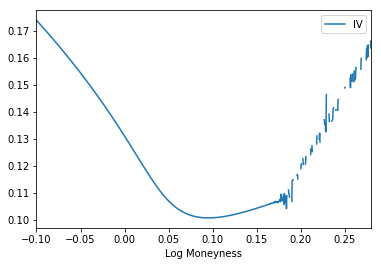

In [26]:
ax = df.plot(x='Log Moneyness', y='IV')
plt.show()

In [27]:
df.to_csv("./data/heston/vol_smile.csv", index=False)

# Labled data for Neural Network

In [30]:
K_T = pd.read_csv("./data/strike_maturity.csv", index_col=0)

In [32]:
K_T.shape

(1000000, 2)

In [31]:
K_T.head()

,Moneyness,Time to Maturity (years)
0,0.820165,0.219184
1,0.926490,0.212487
2,0.834318,0.190719
3,1.053977,0.226441
4,0.802749,0.208923


In [41]:
# Initialisation of df for labeled data
columns = ['lambda', 'vbar', 'eta', 'rho', 'v0', 'iv']
data_nn = pd.DataFrame(index=K_T.index, columns=columns)

# Merge df0 and df
data_nn = pd.concat([K_T, data_nn], axis=1)

In [42]:
data_nn.shape

(1000000, 8)

In [43]:
data_nn.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0,iv
0,0.820165,0.219184,NaN,NaN,NaN,NaN,NaN,NaN
1,0.926490,0.212487,NaN,NaN,NaN,NaN,NaN,NaN
2,0.834318,0.190719,NaN,NaN,NaN,NaN,NaN,NaN
3,1.053977,0.226441,NaN,NaN,NaN,NaN,NaN,NaN
4,0.802749,0.208923,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
np.random.seed(0)

# PARAMETERS
n_samples = K_T.shape[0]

# Heston parameter, bounds by Moodley (2005)
lambd_bounds = [0, 10]
vbar_bounds = [0, 1]
eta_bounds = [0, 5]
rho_bounds = [-1, 0]
v0_bounds = [0, 1]

# Market params
S0 = 1
r = 0
q = 0

In [45]:
data_nn['lambda'] = np.random.uniform(lambd_bounds[0], lambd_bounds[1], n_samples)
data_nn['vbar'] = np.random.uniform(vbar_bounds[0], vbar_bounds[1], n_samples)
data_nn['eta'] = np.random.uniform(eta_bounds[0], eta_bounds[1], n_samples)
data_nn['rho'] = np.random.uniform(rho_bounds[0], rho_bounds[1], n_samples)
data_nn['v0'] = np.random.uniform(v0_bounds[0], v0_bounds[1], n_samples)

In [52]:
data_nn.dtypes

Moneyness                   float64
Time to Maturity (years)    float64
lambda                      float64
vbar                        float64
eta                         float64
rho                         float64
v0                          float64
iv                           object
dtype: object

In [49]:
data_nn.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0,iv
0,0.820165,0.219184,5.488135,0.689556,3.947543,-0.586746,0.164776,NaN
1,0.926490,0.212487,7.151894,0.974517,1.495094,-0.407660,0.337974,NaN
2,0.834318,0.190719,6.027634,0.808059,4.635460,-0.903236,0.203675,NaN
3,1.053977,0.226441,5.448832,0.180819,4.405048,-0.373840,0.979871,NaN
4,0.802749,0.208923,4.236548,0.855412,0.250227,-0.108893,0.200594,NaN


In [57]:
data_nn['iv'] = data_nn.apply(lambda row: heston_pricer(row['lambda'], row['vbar'], row['eta'], 
                                                        row['rho'], row['v0'], r, q, 
                                                        row['Time to Maturity (years)'], S0, row['Moneyness'])[1], axis=1)

2019-04-11 14:43:54,967 - INFO - RuntimeError: Intrinsic 0.09439637468674922. Time 0.23806631920388915. Strike 0.9056036253132508.
2019-04-11 14:44:00,535 - INFO - RuntimeError: Intrinsic 0.04481966661651238. Time 0.2461177972007968. Strike 0.9551803333834876.
2019-04-11 14:44:04,660 - INFO - RuntimeError: Intrinsic 0.20778974527696137. Time 0.166464514553261. Strike 0.7922102547230386.
2019-04-11 14:44:21,534 - INFO - RuntimeError: Intrinsic 0.14638758079872816. Time 0.15244552374332793. Strike 0.8536124192012718.
2019-04-11 14:44:26,413 - INFO - RuntimeError: Intrinsic -0.021880649710339428. Time 0.22387312014401395. Strike 1.0218806497103394.
2019-04-11 14:44:29,285 - INFO - RuntimeError: Intrinsic 0.16306117566175382. Time 0.23691811163629503. Strike 0.8369388243382462.
2019-04-11 14:44:42,716 - INFO - RuntimeError: Intrinsic 0.2481093099139684. Time 0.15000851385302766. Strike 0.7518906900860316.
2019-04-11 14:44:46,009 - INFO - RuntimeError: Intrinsic 0.020068202491489218. Time 0

2019-04-11 14:52:05,949 - INFO - RuntimeError: Intrinsic 0.1994289542221942. Time 0.1855480048660776. Strike 0.8005710457778058.
2019-04-11 14:52:22,099 - INFO - RuntimeError: Intrinsic 0.14006484646302786. Time 0.2393967732749312. Strike 0.8599351535369721.
2019-04-11 14:52:35,341 - INFO - RuntimeError: Intrinsic 0.1899603557606745. Time 0.19075143483191195. Strike 0.8100396442393255.
2019-04-11 14:52:37,138 - INFO - RuntimeError: Intrinsic 0.16759444879987517. Time 0.0983709207479917. Strike 0.8324055512001248.
2019-04-11 14:52:42,923 - INFO - RuntimeError: Intrinsic 0.20781000528542637. Time 0.2034624030372744. Strike 0.7921899947145736.
2019-04-11 14:52:48,329 - INFO - RuntimeError: Intrinsic 0.1184183461405851. Time 0.18760464249247896. Strike 0.8815816538594149.
2019-04-11 14:52:58,120 - INFO - RuntimeError: Intrinsic 0.13950571383163723. Time 0.15777711318012913. Strike 0.8604942861683628.
2019-04-11 14:52:58,495 - INFO - RuntimeError: Intrinsic 0.10226477944806867. Time 0.24476

2019-04-11 14:59:12,467 - INFO - RuntimeError: Intrinsic 0.0906255711301156. Time 0.09789155865969912. Strike 0.9093744288698844.
2019-04-11 14:59:23,514 - INFO - RuntimeError: Intrinsic 0.22714118729045363. Time 0.17594032085959718. Strike 0.7728588127095464.
2019-04-11 14:59:37,927 - INFO - RuntimeError: Intrinsic 0.1948204797609704. Time 0.2215704780725524. Strike 0.8051795202390296.
2019-04-11 14:59:58,900 - INFO - RuntimeError: Intrinsic 0.22993325870822257. Time 0.2408726530313479. Strike 0.7700667412917774.
2019-04-11 15:00:18,866 - INFO - RuntimeError: Intrinsic 0.21138827732611665. Time 0.24810903114843005. Strike 0.7886117226738834.
2019-04-11 15:00:22,369 - INFO - RuntimeError: Intrinsic 0.06955455471763206. Time 0.1854143079737936. Strike 0.9304454452823679.
2019-04-11 15:00:40,146 - INFO - RuntimeError: Intrinsic 0.044389922717488206. Time 0.15936919203997785. Strike 0.9556100772825118.
2019-04-11 15:00:55,309 - INFO - RuntimeError: Intrinsic -0.005776953255010486. Time 0.

2019-04-11 15:10:26,910 - INFO - RuntimeError: Intrinsic 0.1444310812164653. Time 0.2271807915701339. Strike 0.8555689187835347.
2019-04-11 15:10:45,751 - INFO - RuntimeError: Intrinsic 0.12739883739392577. Time 0.22587294047598344. Strike 0.8726011626060742.
2019-04-11 15:10:49,067 - INFO - RuntimeError: Intrinsic 0.09525823150148405. Time 0.1983218314422652. Strike 0.904741768498516.
2019-04-11 15:10:59,961 - INFO - RuntimeError: Intrinsic 0.19957092479070082. Time 0.24155386415140215. Strike 0.8004290752092992.
2019-04-11 15:11:11,374 - INFO - RuntimeError: Intrinsic -0.04210083914724749. Time 0.2030654358321421. Strike 1.0421008391472475.
2019-04-11 15:11:14,775 - INFO - RuntimeError: Intrinsic 0.1903055937334579. Time 0.2274936981142069. Strike 0.8096944062665421.
2019-04-11 15:11:22,949 - INFO - RuntimeError: Intrinsic 0.11044544257660316. Time 0.22000156726047293. Strike 0.8895545574233968.
2019-04-11 15:11:52,147 - INFO - RuntimeError: Intrinsic -0.0027475167538073553. Time 0.2

2019-04-11 15:19:50,191 - INFO - RuntimeError: Intrinsic 0.14702546387127458. Time 0.21949129054809915. Strike 0.8529745361287254.
2019-04-11 15:19:53,275 - INFO - RuntimeError: Intrinsic 0.2116044600884186. Time 0.21968924956113933. Strike 0.7883955399115814.
2019-04-11 15:19:54,561 - INFO - RuntimeError: Intrinsic 0.23809173249042714. Time 0.2106586065433363. Strike 0.7619082675095729.
2019-04-11 15:19:58,438 - INFO - RuntimeError: Intrinsic -0.07372024139509636. Time 0.2267708966359155. Strike 1.0737202413950964.
2019-04-11 15:19:59,340 - INFO - RuntimeError: Intrinsic 0.13835285749964654. Time 0.24384546442546035. Strike 0.8616471425003535.
2019-04-11 15:20:04,362 - INFO - RuntimeError: Intrinsic -0.014938901219333056. Time 0.2396413574854413. Strike 1.014938901219333.
2019-04-11 15:20:05,721 - INFO - RuntimeError: Intrinsic 0.2058307322024634. Time 0.1636143449656157. Strike 0.7941692677975366.
2019-04-11 15:20:17,652 - INFO - RuntimeError: Intrinsic 0.18054018653957038. Time 0.16

2019-04-11 15:27:17,838 - INFO - RuntimeError: Intrinsic -0.017004705153607524. Time 0.22282814586938712. Strike 1.0170047051536075.
2019-04-11 15:27:25,298 - INFO - RuntimeError: Intrinsic 0.13929637631104497. Time 0.18208909085665714. Strike 0.860703623688955.
2019-04-11 15:27:30,562 - INFO - RuntimeError: Intrinsic -0.19334655711064164. Time 0.2313186067985277. Strike 1.1933465571106416.
2019-04-11 15:27:34,241 - INFO - RuntimeError: Intrinsic 0.2446751619855877. Time 0.2105751214333446. Strike 0.7553248380144123.
2019-04-11 15:27:37,136 - INFO - RuntimeError: Intrinsic 0.05087382279483199. Time 0.20295616507008168. Strike 0.949126177205168.
2019-04-11 15:27:44,540 - INFO - RuntimeError: Intrinsic 0.21022733622964207. Time 0.2374811553708201. Strike 0.7897726637703579.
2019-04-11 15:27:48,480 - INFO - RuntimeError: Intrinsic 0.19276015865424745. Time 0.2282876306614789. Strike 0.8072398413457526.
2019-04-11 15:27:49,886 - INFO - RuntimeError: Intrinsic 0.18409786072541245. Time 0.18

2019-04-11 15:35:13,552 - INFO - RuntimeError: Intrinsic 0.2468552990670302. Time 0.2030999407674648. Strike 0.7531447009329698.
2019-04-11 15:35:26,822 - INFO - RuntimeError: Intrinsic 0.1939707594460266. Time 0.2273724439956753. Strike 0.8060292405539734.
2019-04-11 15:35:28,558 - INFO - RuntimeError: Intrinsic 0.021856723042067205. Time 0.2364316624852869. Strike 0.9781432769579328.
2019-04-11 15:35:29,370 - INFO - RuntimeError: Intrinsic -0.09261421315187102. Time 0.1952972581463716. Strike 1.092614213151871.
2019-04-11 15:35:44,183 - INFO - RuntimeError: Intrinsic 0.1553005827463847. Time 0.2360550503665319. Strike 0.8446994172536153.
2019-04-11 15:35:46,223 - INFO - RuntimeError: Intrinsic 0.10530626586864367. Time 0.2285635991249741. Strike 0.8946937341313563.
2019-04-11 15:35:56,788 - INFO - RuntimeError: Intrinsic 0.23847342514711567. Time 0.1949223130238556. Strike 0.7615265748528843.
2019-04-11 15:35:57,418 - INFO - RuntimeError: Intrinsic 0.1608485910380646. Time 0.22478259

2019-04-11 15:42:51,337 - INFO - RuntimeError: Intrinsic 0.20966912296533813. Time 0.23094263237399196. Strike 0.7903308770346619.
2019-04-11 15:42:56,622 - INFO - RuntimeError: Intrinsic 0.20181427036542332. Time 0.2296400829675909. Strike 0.7981857296345767.
2019-04-11 15:42:59,091 - INFO - RuntimeError: Intrinsic 0.11262911997602276. Time 0.2273823863289965. Strike 0.8873708800239772.
2019-04-11 15:43:00,833 - INFO - RuntimeError: Intrinsic -0.04382848771397718. Time 0.2367391832691283. Strike 1.0438284877139772.
2019-04-11 15:43:03,139 - INFO - RuntimeError: Intrinsic 0.1982204104221198. Time 0.1623059953237932. Strike 0.8017795895778802.
2019-04-11 15:43:04,788 - INFO - RuntimeError: Intrinsic 0.1379232679945478. Time 0.225122008329934. Strike 0.8620767320054522.
2019-04-11 15:43:06,720 - INFO - RuntimeError: Intrinsic 0.17823180058249666. Time 0.19286747547382346. Strike 0.8217681994175033.
2019-04-11 15:43:12,837 - INFO - RuntimeError: Intrinsic 0.22044292979177638. Time 0.19503

2019-04-11 15:51:39,591 - INFO - RuntimeError: Intrinsic 0.1972783785495118. Time 0.16587289844882927. Strike 0.8027216214504882.
2019-04-11 15:51:43,281 - INFO - RuntimeError: Intrinsic 0.23287945569940716. Time 0.21316527757027354. Strike 0.7671205443005928.
2019-04-11 15:51:52,654 - INFO - RuntimeError: Intrinsic 0.043217133913381445. Time 0.20195857824066407. Strike 0.9567828660866186.
2019-04-11 15:51:57,084 - INFO - RuntimeError: Intrinsic 0.051155148457763366. Time 0.22808183673212276. Strike 0.9488448515422366.
2019-04-11 15:52:11,692 - INFO - RuntimeError: Intrinsic 0.05743387780453124. Time 0.15715945982441493. Strike 0.9425661221954688.
2019-04-11 15:52:29,527 - INFO - RuntimeError: Intrinsic 0.03745718489422756. Time 0.17725739983996347. Strike 0.9625428151057724.
2019-04-11 15:52:31,476 - INFO - RuntimeError: Intrinsic 0.14942623637112706. Time 0.22306218919464907. Strike 0.8505737636288729.
2019-04-11 15:52:39,714 - INFO - RuntimeError: Intrinsic 0.12342185256275617. Time

In [59]:
data_nn.shape

(1000000, 8)

In [60]:
data_nn.dropna(inplace=True)

In [61]:
data_nn.shape

(999411, 8)

In [63]:
# data_nn = data_nn.iloc[:990000, :]
data_nn.reset_index(drop=True, inplace=True)

# Dissecting labeled pairs into training, validation and testing sets.

data_train, data_val, data_test = np.split(data_nn, [int(9e5), int(9.45e5)], axis=0)

data_train.shape, data_val.shape, data_test.shape

((900000, 8), (45000, 8), (54411, 8))

In [64]:
data_train.to_csv("./data/heston/train.csv", index=False)
data_val.to_csv("./data/heston/val.csv", index=False)
data_test.to_csv("./data/heston/test.csv", index=False)

# Generate rBergomi data

In [72]:
import numpy as np
from matplotlib import pyplot as plt
from rbergomi.rbergomi import rBergomi

%matplotlib inline

In [133]:
def rBergomi_pricer(H, eta, rho, v0, tau, K, S0, MC_samples=40000):
    """Computes European Call price under rBergomi dynamics with MC sampling.
    
    Parameters:
    -----------
        H: Hurst parameter
        eta: volatility of variance
        rho: correlation between stock and vol
        v0: spot variance
        tau: time to maturity in years (365 trading days per year)
        K: strike price
    """
    rB = rBergomi(n=365, N=MC_samples, T=tau, a=H-0.5)
    dW1, dW2 = rB.dW1(), rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho)
    xi = v0
    V = rB.V(Y, xi, eta)
    S = rB.S(V, dB)
    ST = S[:, -1]
    price = np.mean(np.maximum(ST-K, 0))
    
    # check numerical stability
    if price <= 0 or price + K < S0:
        iv = np.nan
        logging.debug("NumStabProblem: Price {}. Intrinsic {}. Time {}. Strike {}.".format(price, S0-K, tau, K))
    else:
        logging.debug("Success: Price {} > intrinsic {}".format(price, S0-K))
        iv = implied_volatility(price, S0, K, tau, 0, 'c')
    return price, iv

In [134]:
# rBergomi parameters 
S0 = 1.0
H = 0.3
eta = 0.3877 
rho = -0.7165 
v0 = 0.0174 
tau = 0.3 
K = 0.9
q = 0

rBergomi_pricer(H, eta, rho, v0, tau, K, S0)

(0.10285879784408716, 0.14044990909591082)

In [147]:
n_samples = 100
S0 = 1.0

# rBergomi parameters
H = 0.4
eta = 0.3877
rho = -0.7165
v0 = 0.0174
T = 0.05

log_moneyness = np.linspace(-0.1, 0.28, n_samples)
strikes = np.exp(log_moneyness) * S0

# Initialisation of df for labeled data
columns = ['Strike','Log Moneyness']
df = pd.DataFrame(np.zeros((n_samples, 2)), columns=columns)

# Filling in parameter data
df['Strike'] = strikes
df['Log Moneyness'] = log_moneyness

In [148]:
df['Price_IV'] = df['Strike'].apply(lambda K: rBergomi_pricer(H, eta, rho, v0, T, K, S0))

In [137]:
df = df.merge(df['Price_IV'].apply(lambda p_iv: pd.Series({'Price': p_iv[0], 'IV': p_iv[1]})), left_index=True, right_index=True)
df.drop(['Price_IV'], axis=1, inplace=True)
df.dropna(inplace=True)
df.head()

,Strike,Log Moneyness,Price,IV
0,0.904837,-0.100000,0.095212,0.170550
2,0.911810,-0.092323,0.088203,0.139987
3,0.915317,-0.088485,0.084740,0.155063
4,0.918837,-0.084646,0.081212,0.146696
6,0.925918,-0.076970,0.074110,0.127096


In [138]:
df.shape

(54, 4)

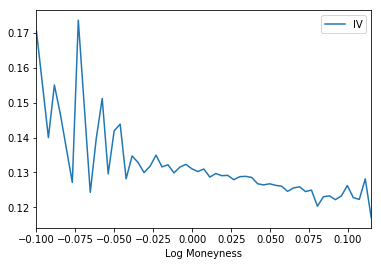

In [139]:
ax = df.plot(x='Log Moneyness', y='IV')
plt.show()

## rBergomi data for NN

In [200]:
K_T = pd.read_csv("./data/strike_maturity.csv", index_col=0)

In [201]:
K_T.shape

(1000000, 2)

In [202]:
K_T.head()

,Moneyness,Time to Maturity (years)
0,0.820165,0.219184
1,0.926490,0.212487
2,0.834318,0.190719
3,1.053977,0.226441
4,0.802749,0.208923


In [204]:
# np.random.seed(0)

# PARAMETERS
n_samples = K_T.shape[0]

# Market params
S0 = 1.

In [205]:
def generate_rBergomi_sample(K, T, param_generator, S0=1.0):
    counter = 0
    while counter < 10:
        params = param_generator()
        H, eta, rho, v0 = params['H'], params['eta'], params['rho'], params['v0']
        _, iv = rBergomi_pricer(H, eta, rho, v0, T, K, S0)
        if np.isnan(iv):
            counter += 1
        else:
            break
    else:
        logging.warning("Tried 10 times, none valid sample obtained.")
    sample = {
        'H': H,
        'eta': eta,
        'rho': rho,
        'v0': v0,
        'iv': iv
    }
    return sample

In [206]:
from scipy.stats import truncnorm

In [207]:
from tqdm import tqdm

tqdm.pandas()

In [208]:
def param_generator(H_generator=truncnorm(-1.2, 8.6, 0.07, 0.05), 
                    eta_generator=truncnorm(-3, 3, 2.5, 0.5), 
                    rho_generator=truncnorm(-0.25, 2.25, -0.95, 0.2), 
                    v0_generator=truncnorm(-2.5, 7, 0.3, 0.1)):
    rslt = {
        'H': H_generator.rvs(),
        'eta': eta_generator.rvs(),
        'rho': rho_generator.rvs(),
        'v0': v0_generator.rvs()
    }
    return rslt

In [209]:
data_nn = K_T.merge(K_T.progress_apply(
    lambda row: pd.Series(generate_rBergomi_sample(row['Moneyness'], row['Time to Maturity (years)'], param_generator, S0)), 
    axis=1), left_index=True, right_index=True)

  0%|                                                    | 103/1000000 [02:02<353:38:29,  1.27s/it]

KeyboardInterrupt: 

In [ ]:
data_nn.shape

In [197]:
data_nn.head()

,Moneyness,Time to Maturity (years),H,eta,rho,v0,iv
0,0.820165,0.219184,0.130827,2.272099,-0.746308,0.346429,0.604637
1,0.926490,0.212487,0.019188,2.193249,-0.941440,0.482971,0.649088
2,0.834318,0.190719,0.118592,3.388821,-0.664146,0.171969,0.429591
3,1.053977,0.226441,0.067560,2.639074,-0.903265,0.391955,0.455982
4,0.802749,0.208923,0.128161,3.091018,-0.913110,0.283059,0.544700
5,0.815038,0.184871,0.057282,2.367293,-0.875522,0.252892,0.542829
6,0.980911,0.238747,0.050566,3.191188,-0.568348,0.366553,0.451591
7,1.016472,0.163820,0.054318,2.154982,-0.856554,0.312540,0.464676
8,0.850134,0.236709,0.071937,2.438977,-0.727755,0.252229,0.493235
9,0.903643,0.242560,0.062889,2.428652,-0.962028,0.215876,0.430546


In [ ]:
data_nn.dropna(inplace=True)

In [ ]:
data_nn.shape

In [ ]:
data_nn.head()

In [ ]:
data_nn.to_csv("./data/rBergomi/labled_data_all.csv", index=False)

In [ ]:
# data_nn = data_nn.iloc[:990000, :]
data_nn.reset_index(drop=True, inplace=True)

# Dissecting labeled pairs into training, validation and testing sets.

data_train, data_val, data_test = np.split(data_nn, [int(9e5), int(9.5e5)], axis=0)

data_train.shape, data_val.shape, data_test.shape

In [ ]:
data_train.to_csv("./data/heston/train.csv", index=False)
data_val.to_csv("./data/heston/val.csv", index=False)
data_test.to_csv("./data/heston/test.csv", index=False)